In [ ]:
# Install required libraries
!pip install -Uq fastai gradio tensorflow tensorflow_datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 

In [1]:
# ----------------------- Part 1: Data Loading and Inspection
# Import Libraries
import tensorflow as tf
import tensorflow_datasets as tfds # We get the rock_paper_scissors dataset from here
from fastai.vision.all import * # FastAI helps us train models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# A.1. Download the data
def load_data():
  # Here, we load the dataset and split it into two sets: training and validation.
    (train_ds, valid_ds), ds_info = tfds.load(
        'rock_paper_scissors',
        split=['train', 'test'],
        as_supervised=True, # This makes it so that the data is (image, label) pairs. Simpler to work with.
        with_info=True, # Gives us useful metadata
        shuffle_files=True # Images will be randomly ordered
    )

    # A.1.1 Inspect the data layout
    print(f"Number of training examples: {ds_info.splits['train'].num_examples}")
    # Output: 2520 - num of labeled training images

    print(f"Number of validation examples: {ds_info.splits['test'].num_examples}")
    # Output: 372 - num of labeled test images

    print(f"Image shape: {ds_info.features['image'].shape}")
    # Output: (300, 300, 3) - 300x300 pixels with 3 color channels (RGB)

    print(f"Classes: {ds_info.features['label'].names}")
    # Output: ['rock', 'paper', 'scissors'] - the possible labels for each image


    # A.1.2 Prepare data for DataBlock
    # We do the following because FastAI expects data in a specific format (PIL image, string), so we convert the data
    def to_fastai(ds):
        items = []
        for img, label in tfds.as_numpy(ds):
            items.append({'image': PILImage.create(img), 'label': ds_info.features['label'].names[label]})
        return items

    # Convert the training and validation datasets into lists of dictionaries
    train_data_list = to_fastai(train_ds)
    valid_data_list = to_fastai(valid_ds)

    # Return the prepared data and dataset info
    return train_data_list, valid_data_list, ds_info

# Run the function to load the data
train_data, valid_data, ds_info = load_data()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.BGYU3N_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.BGYU3N_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
Number of training examples: 2520
Number of validation examples: 372
Image shape: (300, 300, 3)
Classes: ['rock', 'paper', 'scissors']


In [3]:
# ----------------------- Part 2: DataBlock and Dataloaders
# A.2 Create the DataBlock and dataloaders

# Combine all data
all_data_dicts = train_data + valid_data

# Create split indices that tell us where the validation set starts
split_idx = list(range(len(train_data), len(all_data_dicts)))

# --- Define named functions to use in the DataBlock
# I did the following because when I tried to export the learners, I got the "Can't pickle" issue,
# and the solution was to replace the lambda functions in the DataBlock with regularly defined functions
def get_items_from_global_data(_source_arg_is_ignored): # The argument is ignored
    return all_data_dicts

def get_x_from_dict(item_dict):
    return item_dict['image']

def get_y_from_dict(item_dict):
    return item_dict['label']


# A.2.1 Define the blocks
# A.2.2 Define means of getting data into DataBlock
# A.2.3 Define how to get the attributes
# A.2.4 Define data transformations
rps = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Define the type of inputs (PIL images and categories)
    get_items=get_items_from_global_data,
    splitter=IndexSplitter(split_idx), # Specify how to split the dataset into training and validation sets
    get_x=get_x_from_dict,
    get_y=get_y_from_dict,
    item_tfms=Resize(460), # Resizes all images so the shortest side is 460 pixels, this helps ensure images are big enough to crop from later.
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

# Create dataloaders
# This will convert the raw data into batches
dls = rps.dataloaders(all_data_dicts, bs=32) # 32 is a common batch size


Showing sample batch:


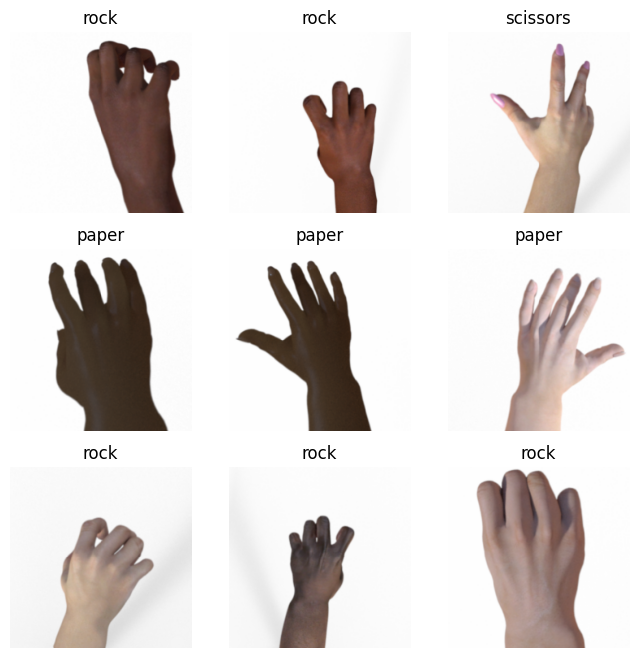


Categories: ['paper', 'rock', 'scissors']
Input batch shape (xb): torch.Size([32, 3, 224, 224])
Target batch shape (yb): torch.Size([32])


In [4]:
# A.3 Inspect the DataBlock via dataloader
# A.3.1 Show batch
print("\nShowing sample batch:")
dls.show_batch(max_n=9, figsize=(8,8)) # Shows 9 images in an 8x8 inch figure
plt.show()

# A.3.2 Check the labels
print(f"\nCategories: {dls.vocab}") # ['paper', 'rock', 'scissors']

# A.3.3 Summarize the DataBlock
# I couldn't use .summary() because I'm using a custom list of dictionaries (all_data_dicts)
# Instead, I'll inspect the shape of a batch manually
xb, yb = dls.one_batch()
print(f"Input batch shape (xb): {xb.shape}") # torch.Size([32, 3, 224, 224])
print(f"Target batch shape (yb): {yb.shape}") # torch.Size([32])


Creating benchmark model...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.352693,0.352617,0.852151,00:17
1,0.094237,0.143948,0.948925,00:19
2,0.038717,0.148538,0.938172,00:16


Confusion Matrix for Benchmark:


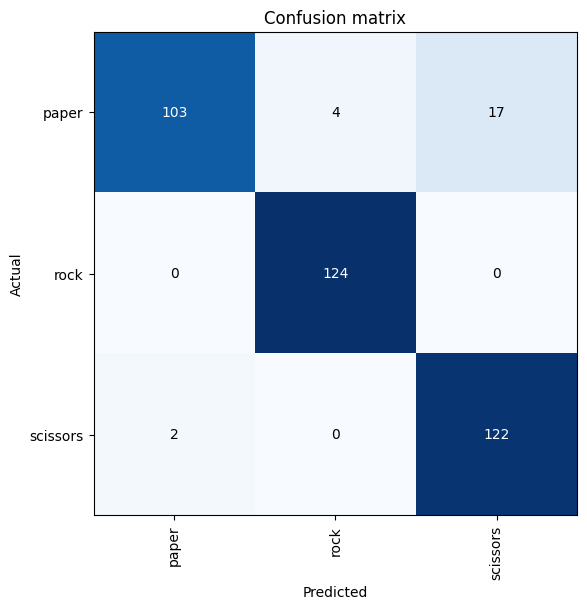

In [5]:
# ----------------------- Part 3: Training and Evaluation
# A.4 Train a simple model
# We'll first train a simple model to establish a baseline

# A.4.1 Create a benchmark
print("\nCreating benchmark model...")
benchmark_learn = vision_learner(dls, resnet18, metrics=accuracy)  # Using resnet18z
benchmark_learn.fit_one_cycle(3, lr_max=1e-3)  # Using a conservative learning rate for stability

# A.4.2 Interpret the model
benchmark_interp = ClassificationInterpretation.from_learner(benchmark_learn)
print("Confusion Matrix for Benchmark:")
benchmark_interp.plot_confusion_matrix(figsize=(6,6))
plt.show() # Plot for visualizing the benchmark model's performance


Training main model with advanced techniques...

Finding optimal learning rate:



Chosen learning rate based on suggestion: 1.00e-03


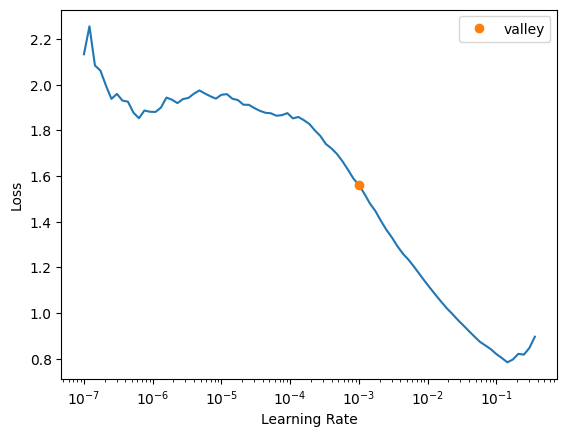

In [6]:
# Now we'll use more advanced techniques to train our model
print("\nTraining main model with advanced techniques...")
learn = vision_learner(dls, resnet18, metrics=accuracy) # Initializing a learner object using resnet18

# B.1 Learning Rate Finder
# B.2 Finder Algorithm implementation
print("\nFinding optimal learning rate:")
# The learning rate finder tries different rates to see which works best. It starts with
# a very small lr, and then gradually increases it as long as new loss < old loss
lr_find_suggestions = learn.lr_find() # It returns suggestions about where the best learning rate might be

# Use one of the suggested lrs
# We go with the "valley" point, but if it doesn't exist, we go with suggestion(). 1e-3 is the safe default.
chosen_lr = lr_find_suggestions.valley if lr_find_suggestions.valley else lr_find_suggestions.suggestion() if lr_find_suggestions.suggestion() else 1e-3
print(f"\nChosen learning rate based on suggestion: {chosen_lr:.2e}")


Training with frozen layers...


epoch,train_loss,valid_loss,accuracy,time
0,0.413940,0.264682,0.905914,00:17
1,0.101458,0.370639,0.889785,00:17
2,0.039724,0.291615,0.919355,00:17
3,0.022838,0.237905,0.924731,00:17
4,0.008599,0.225737,0.930108,00:19



Fine-tuning with discriminative learning rates...


epoch,train_loss,valid_loss,accuracy,time
0,0.007556,0.198419,0.932796,00:17
1,0.005533,0.082920,0.973118,00:17
2,0.005078,0.073889,0.981183,00:18



Confusion Matrix:


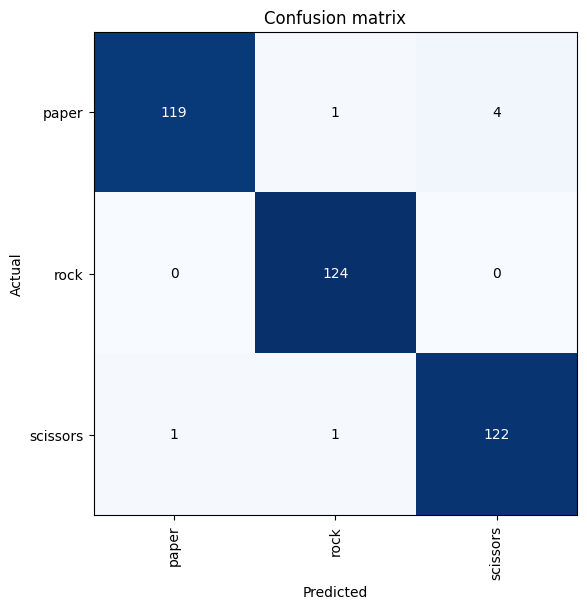


Top Losses:


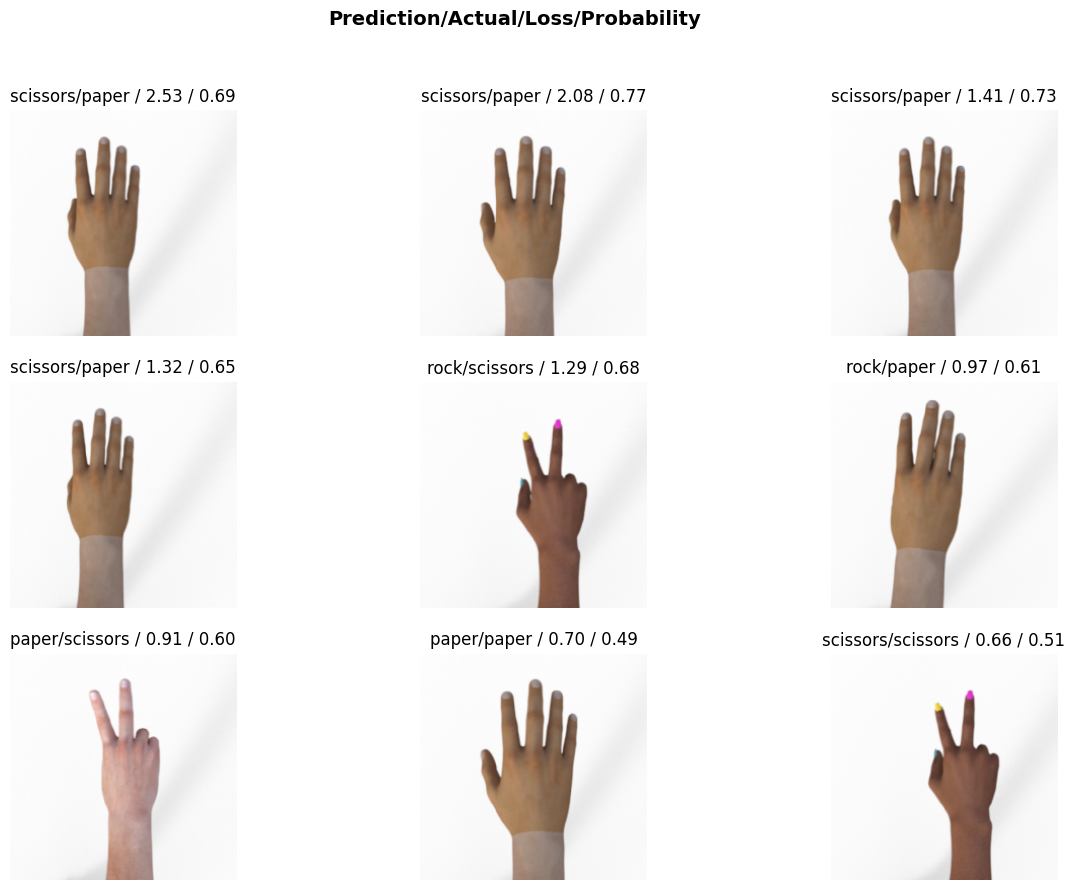


Project execution completed.


In [7]:
# B.3 Transfer Learning: train with frozen layers
print("\nTraining with frozen layers...")
learn.fit_one_cycle(5, lr_max=chosen_lr) # Using the chosen learning rate

# B.4 Discriminative Learning Rates
print("\nFine-tuning with discriminative learning rates...")
learn.unfreeze() # We unfreeze all layers to fine-tune the entire model

if chosen_lr:
    learn.fit_one_cycle(3, lr_max=slice(chosen_lr/100, chosen_lr/10)) # slice tells fastai to use a range of learning rates
else:
    print("Skipping fine-tuning as chosen_lr was not determined.")


# A.4.2 Interpret the model
interp = ClassificationInterpretation.from_learner(learn) # this helps us analyze performance

# A.4.3 Confusion matrix
print("\nConfusion Matrix:")
interp.plot_confusion_matrix(figsize=(6,6))
plt.show()

# examples our model found hardest to classify
print("\nTop Losses:")
interp.plot_top_losses(k=9, figsize=(15,10)) # Show top k losses
plt.show()

print("\nProject execution completed.")

In [8]:
# Export the learner object
learn.export('rps_model.pkl')
print("\nAttempting to export the learner...")
try:
    learn.export('rps_model.pkl')
    print("Learner exported successfully to rps_model.pkl!")
except Exception as e:
    print(f"Error during export: {e}")
    import traceback
    traceback.print_exc()


Attempting to export the learner...
Learner exported successfully to rps_model.pkl!
